In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
from scipy.stats import binom
exec(open('../../analysis/ppVAF_calculations/ppVAF_utils.py').read())

set1_colors = plt.get_cmap("Set1").colors
set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# root directory where processed mutation data are stored
# if using the zenodo data, this should point to the location of the base zenodo directory 
data_dir = ""

# directory where the purity data and the table with clonal counts and polyclonal calls are saved
# defaults to path in repo relative to current WD
repo_data_dir = "../../data/"

save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [3]:
clonal_calls = pd.read_csv(repo_data_dir+"clonal_count_estimation/clonal_SNVs_WES_WGS.csv", index_col=0)
WGS_maf = pd.read_csv(data_dir+"HTAN_WGS_filtered_ppVAFs.maf", sep="\t")
WES_maf = pd.read_csv(data_dir+"HTAN_WES_filtered_ppVAFs.maf", sep="\t")

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (85,87,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
annot_dir = repo_data_dir+"scATACseq_annotations/"
sc_types = pd.read_csv(annot_dir+"scATAC_celltype_fracs.csv", index_col=0)

HTAN_WGS_CN_purity = pd.read_csv(repo_data_dir+"HTAN_WGS_facets_sequenza_purities.csv", index_col=0)
HTAN_WES_CN_purity = pd.read_csv(repo_data_dir+"HTAN_WES_facets_sequenza_purities.csv", index_col=0)

HTAN_WGS_CN_purity = HTAN_WGS_CN_purity[HTAN_WGS_CN_purity["stage"] != "AdCa"]
HTAN_WES_CN_purity = HTAN_WES_CN_purity[HTAN_WES_CN_purity["stage"] != "AdCa"]

In [5]:
HTAN_WGS_CN_purity["is_poly"] = clonal_calls["is_poly"]
HTAN_WES_CN_purity["is_poly"] = clonal_calls["is_poly"]


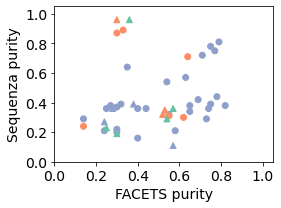

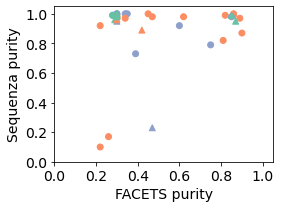

In [6]:
# EXTENDED DATA FIGURE 4a-b

stage_palette = dict(zip(["Mucosa", "Benign", "Dysplasia", "AdCa"], set2_colors[:4]))

only_poly = HTAN_WGS_CN_purity[HTAN_WGS_CN_purity["is_poly"]]
only_mono = HTAN_WGS_CN_purity[~HTAN_WGS_CN_purity["is_poly"]]

plt.subplots(1,1,figsize=(4,3))
plt.scatter(only_mono["purity_facets"], only_mono["purity_sequenza"], c=[stage_palette[x] for x in only_mono["stage"]], marker="o")
plt.scatter(only_poly["purity_facets"], only_poly["purity_sequenza"], c=[stage_palette[x] for x in only_poly["stage"]], marker="^")
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.xlabel("FACETS purity", fontsize=14)
plt.ylabel("Sequenza purity", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4a_facets_sequenza_WGS.pdf")
plt.show()

only_poly = HTAN_WES_CN_purity[HTAN_WES_CN_purity["is_poly"]]
only_mono = HTAN_WES_CN_purity[~HTAN_WES_CN_purity["is_poly"]]

plt.subplots(1,1,figsize=(4,3))
plt.scatter(only_mono["purity_facets"], only_mono["purity_sequenza"], c=[stage_palette[x] for x in only_mono["stage"]], marker="o")
plt.scatter(only_poly["purity_facets"], only_poly["purity_sequenza"], c=[stage_palette[x] for x in only_poly["stage"]], marker="^")
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.xlabel("FACETS purity", fontsize=14)
plt.ylabel("Sequenza purity", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4b_facets_sequenza_WES.pdf")
plt.show()

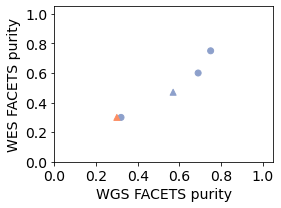

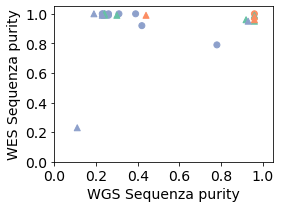

In [7]:
# EXTENDED DATA FIGURE 4c-d

merged_purities = HTAN_WGS_CN_purity.join(HTAN_WES_CN_purity, how="inner", lsuffix="_WGS", rsuffix="_WES")

only_poly = merged_purities[merged_purities["is_poly_WGS"]]
only_mono = merged_purities[~merged_purities["is_poly_WGS"]]

plt.subplots(1,1,figsize=(4,3))
plt.scatter(only_mono["purity_facets_WGS"], only_mono["purity_facets_WES"], c=[stage_palette[x] for x in only_mono["stage_WGS"]], marker="o")
plt.scatter(only_poly["purity_facets_WGS"], only_poly["purity_facets_WES"], c=[stage_palette[x] for x in only_poly["stage_WGS"]], marker="^")
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.xlabel("WGS FACETS purity", fontsize=14)
plt.ylabel("WES FACETS purity", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4c_facets_WGS_WES.pdf")
plt.show()

plt.subplots(1,1,figsize=(4,3))
plt.scatter(only_mono["purity_sequenza_WGS"], only_mono["purity_sequenza_WES"], c=[stage_palette[x] for x in only_mono["stage_WGS"]], marker="o")
plt.scatter(only_poly["purity_sequenza_WGS"], only_poly["purity_sequenza_WES"], c=[stage_palette[x] for x in only_poly["stage_WGS"]], marker="^")
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.xlabel("WGS Sequenza purity", fontsize=14)
plt.ylabel("WES Sequenza purity", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4d_sequenza_WGS_WES.pdf")
plt.show()

In [8]:
def plot_dist(maf, active_ax, plot_var="vaf", group_var=None, purity=None, common_norm=True, plot_color="darkgrey"):
    if group_var is None:
        sns.kdeplot(x=maf[plot_var], common_norm=common_norm, ax=active_ax, legend=None, color=plot_color)
    else:
        sns.kdeplot(x=maf[plot_var], hue=maf[group_var], common_norm=common_norm, ax=active_ax, legend=None, color=plot_color)
        
    if purity is not None:
        active_ax.axvline(x=purity/2, color="k", linestyle="dashed")
    active_ax.set_xlim(0,1)
    return

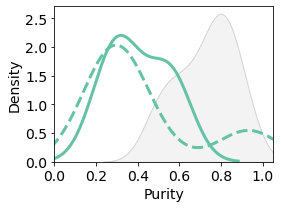

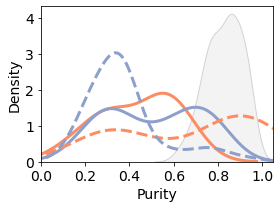

In [9]:
# EXTENDED DATA FIGURE 4e-f

fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.kdeplot(HTAN_WGS_CN_purity[HTAN_WGS_CN_purity["stage"]=="Mucosa"]["purity_facets"], common_norm=True, color=set2_colors[0], ax=ax, linewidth=3)
sns.kdeplot(HTAN_WGS_CN_purity[HTAN_WGS_CN_purity["stage"]=="Mucosa"]["purity_sequenza"], common_norm=True, color=set2_colors[0], ax=ax, linewidth=3, linestyle="dashed")

sns.kdeplot(sc_types[sc_types["DiseaseState"]=="Unaffected"]["epithelial"], common_norm=True, fill="lightgrey", color="lightgrey", ax=ax)
ax.set_xlim(0,1.05)
plt.xlabel("Purity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4e_mucosa_scATACseq_purity.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.kdeplot(HTAN_WGS_CN_purity[HTAN_WGS_CN_purity["stage"]=="Benign"]["purity_facets"], common_norm=True, color=set2_colors[1], ax=ax, linewidth=3)
sns.kdeplot(HTAN_WGS_CN_purity[HTAN_WGS_CN_purity["stage"]=="Dysplasia"]["purity_facets"], common_norm=True, color=set2_colors[2], ax=ax, linewidth=3)

sns.kdeplot(HTAN_WGS_CN_purity[HTAN_WGS_CN_purity["stage"]=="Benign"]["purity_sequenza"], common_norm=True, color=set2_colors[1], ax=ax, linewidth=3, linestyle="dashed")
sns.kdeplot(HTAN_WGS_CN_purity[HTAN_WGS_CN_purity["stage"]=="Dysplasia"]["purity_sequenza"], common_norm=True, color=set2_colors[2], ax=ax, linewidth=3, linestyle="dashed")
sns.kdeplot(sc_types[sc_types["DiseaseState"]=="Polyp"]["epithelial"], common_norm=True, fill="lightgrey", color="lightgrey", ax=ax)
ax.set_xlim(0,1.05)
plt.xlabel("Purity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4f_polyp_scATACseq_purity.pdf")
plt.show()

In [10]:
t_alt = 20
t_depth = 100

marginalized = single_diploid_mutation_posterior(t_alt, t_depth, 0.8)

purity_dist = stats.norm.pdf(np.linspace(0.01, 1, 100), loc=0.8, scale=0.1)
marginalized_uncertain = single_diploid_mutation_posterior_puritydist(t_alt, t_depth, purity_dist)

purity_dist = stats.norm.pdf(np.linspace(0.01, 1, 100), loc=0.8, scale=0.3)
marginalized_more_uncertain = single_diploid_mutation_posterior_puritydist(t_alt, t_depth, purity_dist)

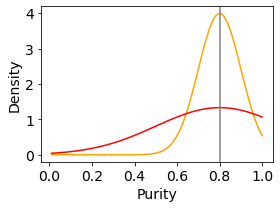

In [11]:
# EXTENDED DATA FIGURE 4g

fig, ax = plt.subplots(1,1, figsize=(4,3))
plt.plot(np.linspace(0.01, 1, 100), stats.norm.pdf(np.linspace(0.01, 1, 100), loc=0.8, scale=0.1), color="orange")
plt.plot(np.linspace(0.01, 1, 100), stats.norm.pdf(np.linspace(0.01, 1, 100), loc=0.8, scale=0.3), color="red")
plt.axvline(x=0.8, color="grey")
plt.xlabel("Purity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4g_purity_sim.pdf")
plt.show()

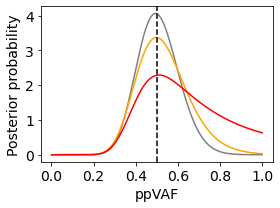

In [12]:
# EXTENDED DATA FIGURE 4h

true_frequency = (t_alt/t_depth)*2/0.8

fig, ax = plt.subplots(1,1, figsize=(4,3))
plt.plot(np.linspace(0.001, 1, 1000), marginalized, color="grey")
plt.plot(np.linspace(0.001, 1, 1000), marginalized_uncertain, "orange")
plt.plot(np.linspace(0.001, 1, 1000), marginalized_more_uncertain, "red")
plt.axvline(x=true_frequency, color="k", linestyle="dashed")
plt.xlabel("ppVAF", fontsize=14)
plt.ylabel("Posterior probability", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4h_ppVAF_sim.pdf")
plt.show()

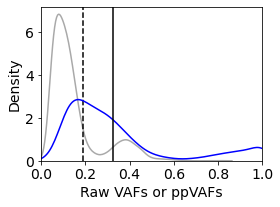

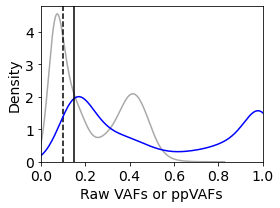

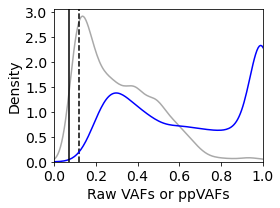

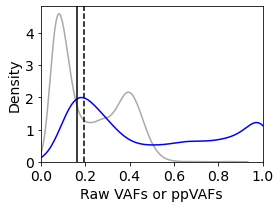

In [13]:
# EXTENDED DATA FIGURE 4i-l

sample_to_plot = "G025"
fig, ax = plt.subplots(1,1,figsize=(4, 3))
to_plot = WGS_maf[WGS_maf["Tumor_Sample_Barcode"] == sample_to_plot]
plot_purity = HTAN_WGS_CN_purity.loc[sample_to_plot]["purity_sequenza"]
plot_purity_facets = HTAN_WGS_CN_purity.loc[sample_to_plot]["purity_facets"]
plot_dist(to_plot, ax, purity=plot_purity)
plot_dist(to_plot, ax, plot_var="ppVAF", plot_color="blue")
ax.axvline(x=plot_purity_facets/2, color="k")
plt.xlabel("Raw VAFs or ppVAFs", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4i_G025_purity.pdf")
plt.show()

sample_to_plot = "A002C010"
fig, ax = plt.subplots(1,1,figsize=(4, 3))
to_plot = WGS_maf[WGS_maf["Tumor_Sample_Barcode"] == sample_to_plot]
plot_purity = HTAN_WGS_CN_purity.loc[sample_to_plot]["purity_sequenza"]
plot_purity_facets = HTAN_WGS_CN_purity.loc[sample_to_plot]["purity_facets"]
plot_dist(to_plot, ax, purity=plot_purity)
plot_dist(to_plot, ax, plot_var="ppVAF", plot_color="blue")
ax.axvline(x=plot_purity_facets/2, color="k")
plt.xlabel("Raw VAFs or ppVAFs", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4j_A002C010_purity.pdf")
plt.show()

sample_to_plot = "G3"
fig, ax = plt.subplots(1,1,figsize=(4, 3))
to_plot = WGS_maf[WGS_maf["Tumor_Sample_Barcode"] == sample_to_plot]
plot_purity = HTAN_WGS_CN_purity.loc[sample_to_plot]["purity_sequenza"]
plot_purity_facets = HTAN_WGS_CN_purity.loc[sample_to_plot]["purity_facets"]
plot_dist(to_plot, ax, purity=plot_purity)
plot_dist(to_plot, ax, plot_var="ppVAF", plot_color="blue")
ax.axvline(x=plot_purity_facets/2, color="k")
plt.xlabel("Raw VAFs or ppVAFs", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4k_G3_purity.pdf")
plt.show()

sample_to_plot = "F074B"
fig, ax = plt.subplots(1,1,figsize=(4, 3))
to_plot = WGS_maf[WGS_maf["Tumor_Sample_Barcode"] == sample_to_plot]
plot_purity = HTAN_WGS_CN_purity.loc[sample_to_plot]["purity_sequenza"]
plot_purity_facets = HTAN_WGS_CN_purity.loc[sample_to_plot]["purity_facets"]
plot_dist(to_plot, ax, purity=plot_purity)
plot_dist(to_plot, ax, plot_var="ppVAF", plot_color="blue")
ax.axvline(x=plot_purity_facets/2, color="k")
plt.xlabel("Raw VAFs or ppVAFs", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4l_F074B_purity.pdf")
plt.show()
